TITLE: Types of MineCraft Players that should be Recruited to Maximize Data for Research

INTRODUCTION:
A research group led by Frank Wood in Computer Science at UBC is collecting data about how people play video games. To conduct this study, they set up a MineCraft server and recorded how players played the game. They collected basic information about the player like their name, age, and gender, as well as data about their experience level with the game, subscription status to a game-related newsletter, and their total hours played.

This report aims to answer the following question: "Can a player's age predict the hours they spend playing MineCraft in players.csv?"

The dataset used to answer this question is contained within the file "players.csv". This dataset contains 196 rows of observations and 7 variables:
- experience: a character data type that describes the level of expertise of the player with the MineCraft game. There are 5 possible observations: "amateur", "beginner", "regular", "pro", and "veteran".
- subscribe: a logical data type that shares whether the player has subscribed to a game-related newsletter or not. Possible observations are "TRUE", for having subscribed, or "FALSE", for not having a subscription.
- hashedEmail: a character data type where the observation is the email address of the player that had a hashing algorithm applied to protect the user's privacy.
- played_hours: a double data type where the observations are numerical values that represent the number of hours the player has spent playing the game. Values seen are within the range of 0-223.1.
- name: a character data type representing the first names of the players studied.
- gender: a character data type where the possible inputs are "Male", "Female", "Non-binary", "Two-Spirited", "Agender", "Prefer not to say", and "Other".
- Age: a double data type where the values represent the age of the players, with one cell containing "NA".

An issue that I notice right away in the data is that the column names are not as clean as they could be, with some names containing a _ with others having two words written as one, or some with an uppercase letter. Additionally, because the question requires creating a regression model, I would need to alter the experience variable so that it can be represented on a numerical scale.

METHODS & RESULTS:
- load and wrangle data set to prepare for visualization using columns of interest
- create scatterplots to initially see if there is a relationship between the two variables and check type of relationship
- since response variable is numerical, create a regression model
- relationship is not quite linear, so use cross-validation to create a K-NN regression model rather than a simple linear one

In [123]:
#loading the tidyverse package
library(tidyverse)
library(tidymodels)
set.seed(1234)

In [124]:
#loading the data
players_data <- read_csv("data/players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [125]:
#first select columns of interest
players_data <- select(players_data, Age, played_hours)
head(players_data)

Age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


In [126]:
#rename column to be all lowercase
players <- players_data |> mutate(age = Age) |>
    select(age, played_hours) |>
    filter(age != "NA")
head(players)

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


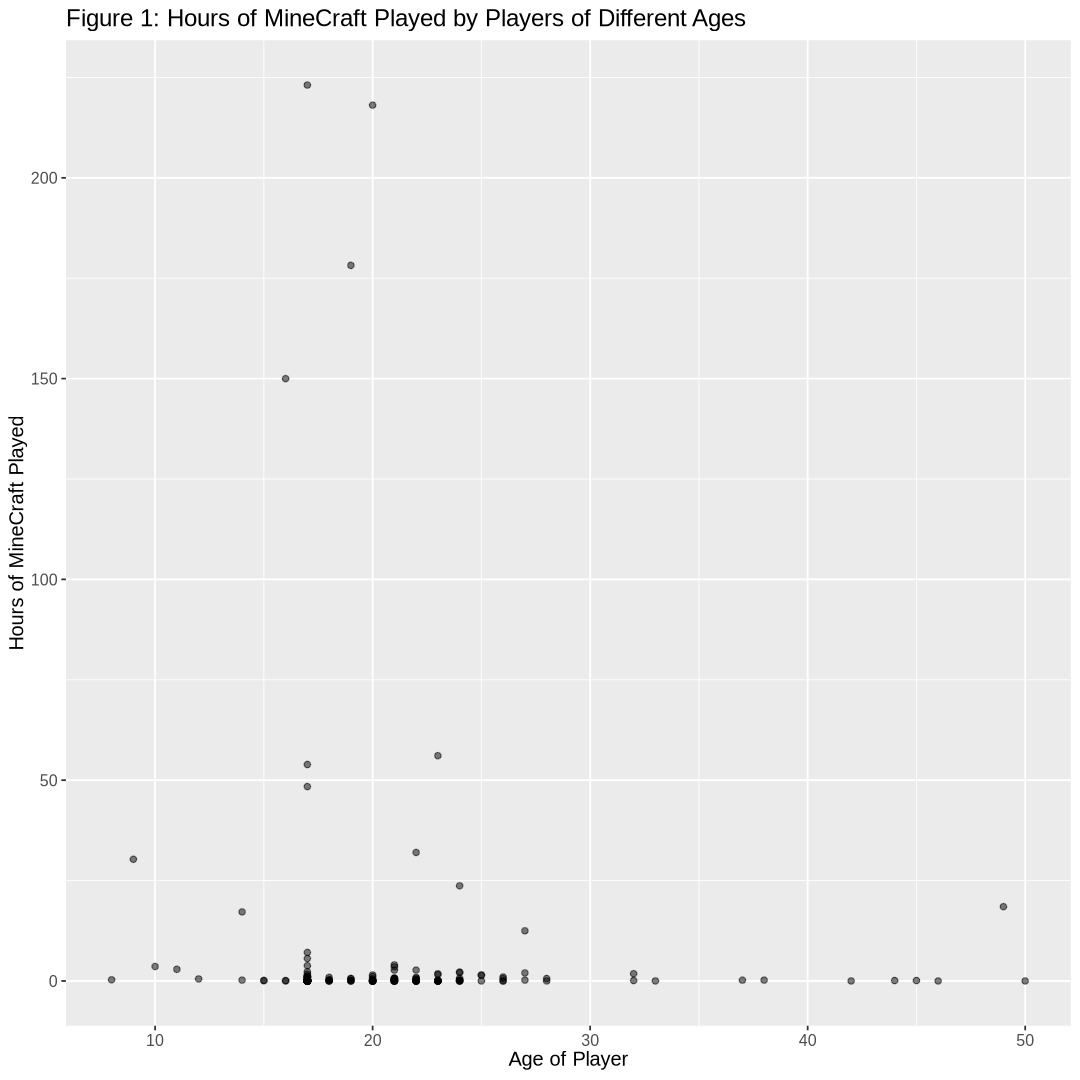

In [127]:
#create visualization of dataset for exploratory data analysis
options(repr.plot.width = 9, repr.plot.height = 9)

players_graph <- players |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    ggtitle("Figure 1: Hours of MineCraft Played by Players of Different Ages") +
    labs(x = "Age of Player", y = "Hours of MineCraft Played") +
    theme(text = element_text(size = 12))
players_graph

We can see that in Figure 1 it is quite difficult to clearly visualize a trend because of how many players played no hours. Thankfully, due to the lowered opacity of the data points, we can also see that most of the students studied were around the ages 15-30, many of whom played no hours or very minimal hours of MineCraft. Furthermore, the highest times played are by players within an age range of around 15-25. In order to predict the hours played by players of different ages to figure out who to focus recruiting efforts to, it would be better to eliminate the data points from players who played 0 hours to see who played a lot or very little rather than having the model focus on players who did not play at all. 

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
21,0.7
21,0.1
17,0.1
23,1.6


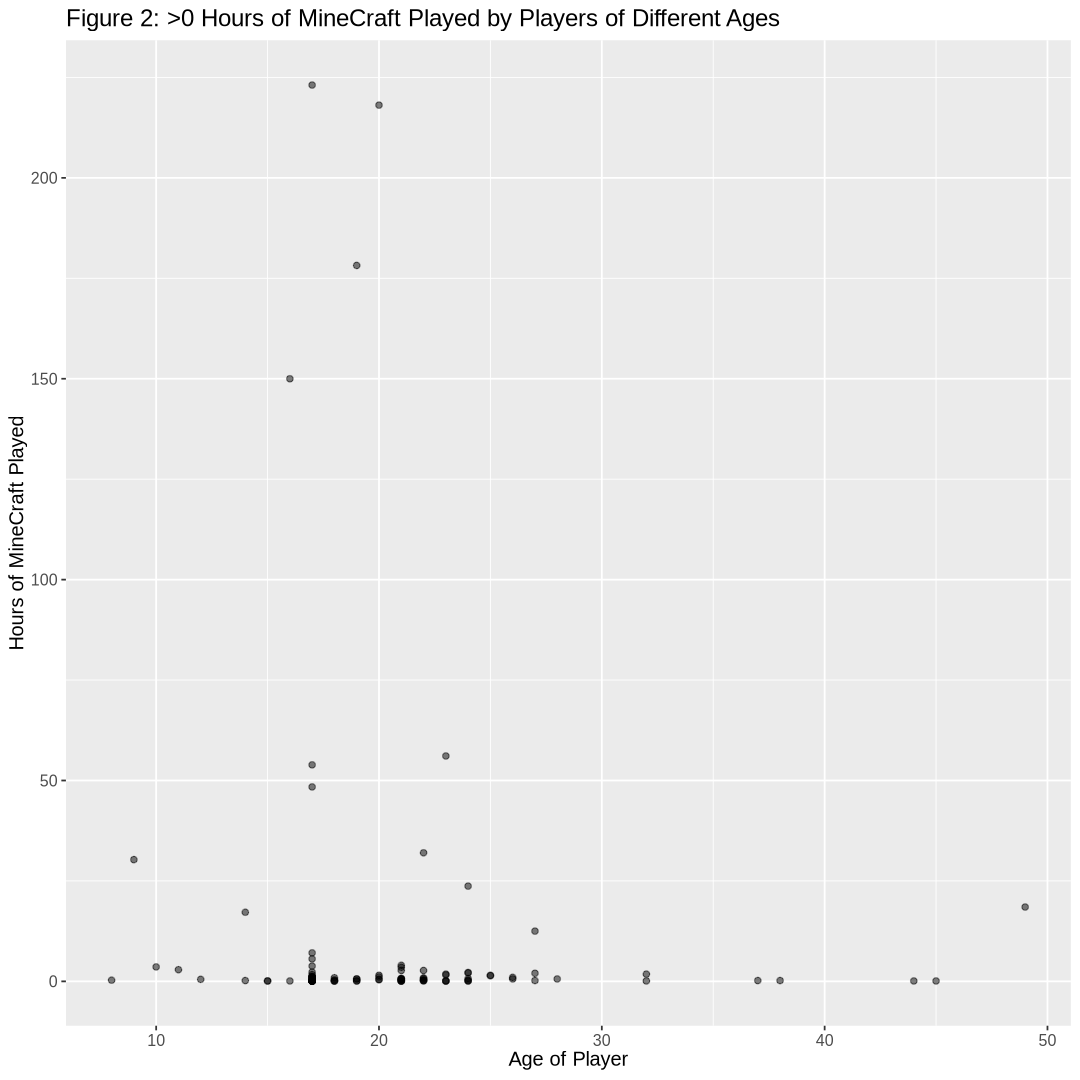

In [128]:
players_0 <- players |>
    filter(played_hours > 0)
head(players_0)

players_graph_0 <- players_0 |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    ggtitle("Figure 2: >0 Hours of MineCraft Played by Players of Different Ages") +
    labs(x = "Age of Player", y = "Hours of MineCraft Played") +
    theme(text = element_text(size = 12))
players_graph_0

We can see that the relationship between the age of the player and their hours played still is not clearly linear, so we should use a K-NN regression model instead of a simple linear regression model and we must use cross-validation to check which K value is optimal for this model. K-NN regression model is quite simple to use, so there are not many assumptions about the data required with this method. A potential limitation or weakness is that we cannot use the model to extrapolate any response variable values beyond what we have in the data set currently.

To apply this model, I will split the data into a training and testing model. Then, I will perform a 5-fold cross-validation to try values of K from 1-20. 

In [129]:
#split the data into training and testing sets
players_split <- initial_split(players_0, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [138]:
#perform cross-validation
players_recipe <- recipe(played_hours ~ age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

gridvals <- tibble(neighbors = seq(from = 1, to = 20))

players_result <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")
head(players_result)
tail(players_result)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,38.37940,5,13.49917,Preprocessor1_Model01
2,rmse,standard,41.50917,5,13.41987,Preprocessor1_Model02
3,rmse,standard,42.71564,5,10.85417,Preprocessor1_Model03
4,rmse,standard,41.35574,5,10.66093,Preprocessor1_Model04
5,rmse,standard,40.26565,5,10.81147,Preprocessor1_Model05
6,rmse,standard,38.42447,5,10.49249,Preprocessor1_Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,36.88533,5,11.08430,Preprocessor1_Model15
16,rmse,standard,37.16224,5,11.27931,Preprocessor1_Model16
17,rmse,standard,38.17895,5,10.79063,Preprocessor1_Model17
18,rmse,standard,37.74936,5,10.71885,Preprocessor1_Model18
19,rmse,standard,37.50801,5,10.82359,Preprocessor1_Model19
20,rmse,standard,37.04943,5,11.11029,Preprocessor1_Model20


In [131]:
#we can now choose the value of K producing the smallest RMSE
players_min <- players_result |>
    filter(mean == min(mean))
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,35.30357,5,14.09413,Preprocessor1_Model09


By performing cross-validation with K values in the range of 1-20, we can see that K = 13 gives us the smallest RMSE, so that is the value that we will use for the regression model. We can now create another spec object with this K value and actually train our model.

In [132]:
players_spec13 <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec13) |>
    fit(data = players_train)
players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 15.25461
Minimal mean squared error: 1708.056
Best kernel: rectangular
Best k: 13

In [133]:
#now we can use this workflow to predict the testing set values
players_summary <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,15.70117


We can see that the RMSE value for the performance of the model on the testing data is quite high, which is not preferred. Now, we will produce another visualization of this analysis, where we superimpose the line produced by the K-NN regression model over the data points of the original data set to see how our model produced the predictions for the testing data.

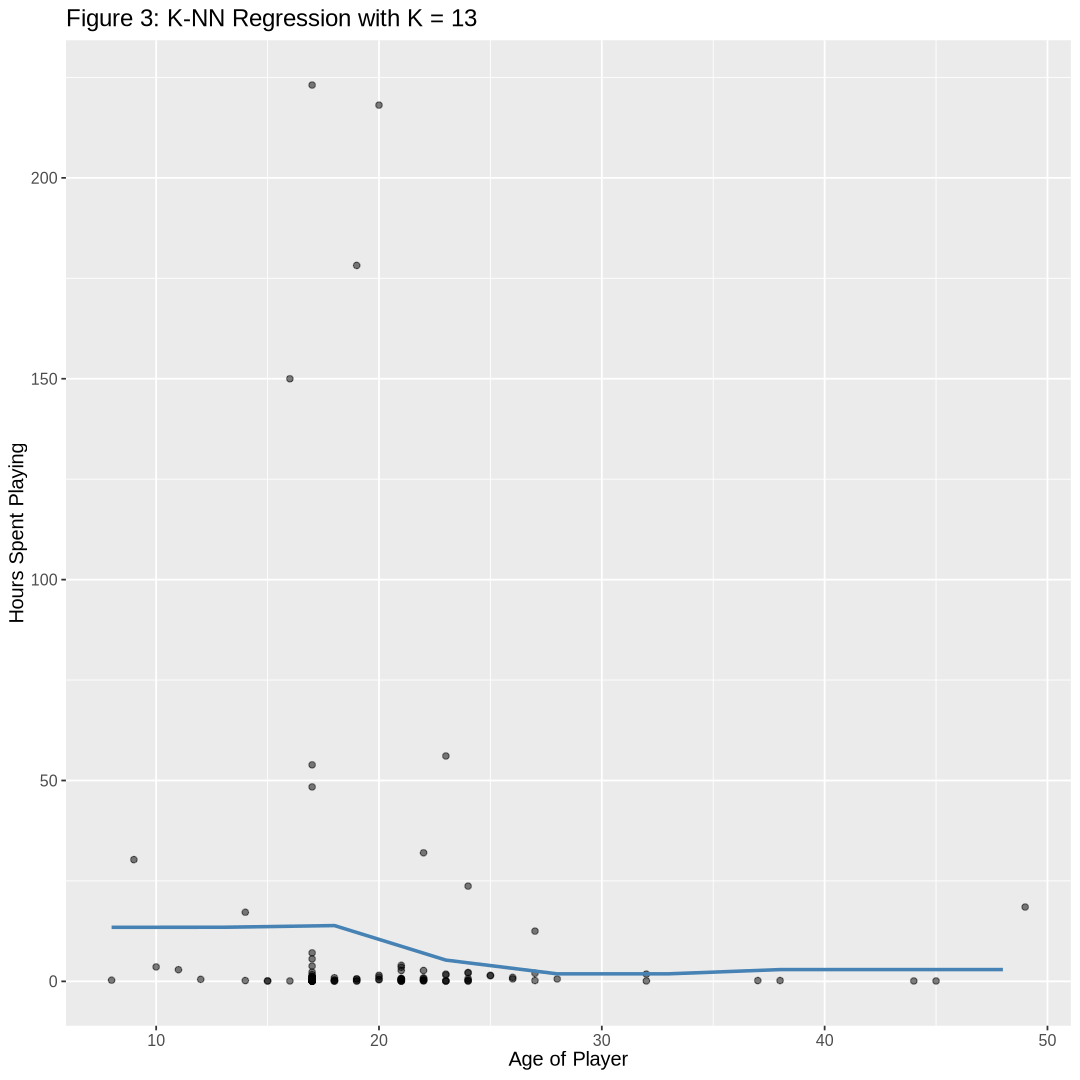

In [137]:
age_grid <- tibble(
        age = seq(
            from = players_0 |> select(age) |> min(),
            to = players_0 |> select(age) |> max(),
            by = 5))

players_pred <- players_fit |>
    predict(age_grid) |>
    bind_cols(age_grid) 

players_plot <- players_0 |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    geom_line(data = players_pred, 
              mapping = aes(x = age, y = .pred), 
              color = "steelblue", 
              linewidth = 1) +
    labs(x = "Age of Player", y = "Hours Spent Playing") +
    ggtitle("Figure 3: K-NN Regression with K = 13") +
    theme(text = element_text(size = 12))
players_plot